In [4]:
import mltfm.generate_data
from DL_TFM.scripts.tracNet import TracNet
from DL_TFM.scripts.training_and_evaluation import predictTrac
from DL_TFM.scripts.data_preparation import matFiles_to_npArray, reshape

from scipy.io import savemat, loadmat

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import keras

# Datasets for TFM

In this notebook I conduct an analysis of available datasets and data generating methods for TFM.

### 1. [Artificial datasets](https://cmu.app.box.com/s/n34hbfopwa3r6rftvtfn4ckc403hk43d) by Wang and Lin 

####  1.1 Training

Three datasets of different resolutions, derived from a cell migration model, were designed for training purposes.

| Class | #Samples | Sample size (h x w x ch) | Young's modulus (N/pixel) | Labeled (y/n)
| :-: | :-: | :-: | :-: | :-: |
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns) |  104 x 104 x 2 | 10 | y
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns)| 160 x 160 x 2 | 6.5 | y
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns)| 256 x 256 x 2 | 4.1 | y

Additional design choices:
- 184 simulated amoeboid or mesenchymal cells in total (ungrouped)
- each image augmented by seven-fold 45° rotation
- Poisson ratio ν of simulated substrate fixed at 0.45
- from stress fields of size 160 x 160, corresponding fields for other sizes obtained by NN-interpolation
- 81 radial patterns per dataset to enhance resolution and symmetry

Exemplary visualizations of sample `MLData001-00.mat` and radial pattern `MLData160.mat`.

<IPython.core.display.Javascript object>


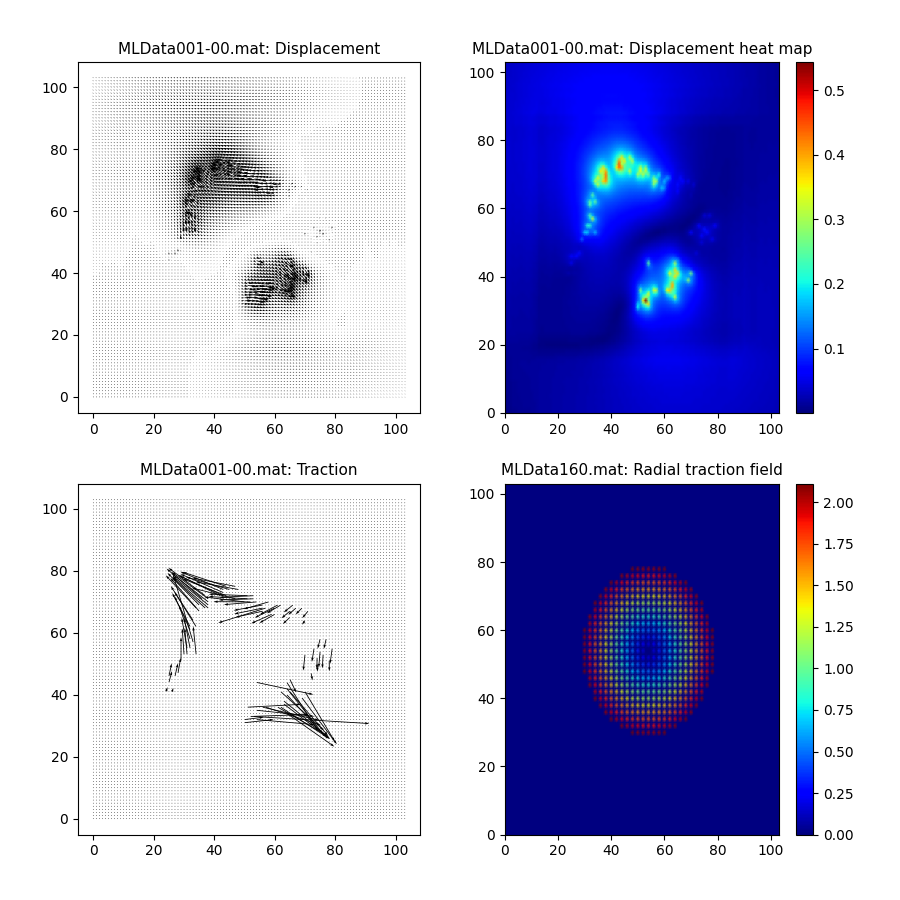

Text(0.5, 1.0, 'MLData160.mat: Radial traction field')

In [43]:
samples = matFiles_to_npArray('comparables/01') 

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(samples[2]['dspl'][:,:,0], samples[2]['dspl'][:,:,1], scale=10)
axs[0, 0].set_title('MLData001-00.mat: Displacement', {'fontsize': 11})

C = np.sqrt(samples[2]['dspl'][:,:,0] **2 + samples[2]['dspl'][:,:,1] ** 2)
im = axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0, 1])
axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 1].set_title('MLData001-00.mat: Displacement heat map', {'fontsize': 11})

fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[1, 0].quiver(samples[3]['trac'][:,:,0], samples[3]['trac'][:,:,1], scale=10)
axs[1, 0].set_title('MLData001-00.mat: Traction', {'fontsize': 11})

C = np.sqrt(samples[0]['trac'][:,:,0] **2 + samples[0]['trac'][:,:,1] ** 2)
im = axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1, 1])
axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1, 1].set_title('MLData160.mat: Radial traction field', {'fontsize': 11})

#### 1.2 Tests 

Labeled test data was in principle generated similarly to the training data. Cell types are now grouped and different experimental conditions were mimicked.

| Category | #Samples | Available Sizes (104, 160, 256) | Labeled (y / n) | Description
| :-: | :-: | :-: | :-: | :-: | 
| generic | 17 | 104, 160, 256 | y | generic cell shape
| keratocyte | 10 | 160 | y | keratocyte cell shape
| neuron | 16 | 160 | y | neuron cell shape
| elasticity | 85 | 160 | y | generic cells on substrates with varying ν
| magnification | 17 | 160 | y | varying microscope lenses
| tracScale | 17 | 160 | y | varying stress magnitude

Additional design choices:
- Young's modulus fixed at 10670 Pa (typical for experimental setup)
- maximal stress magnitude set at 6000 Pa (typical for experimental setup)
- Gaussian noise at inference time generated from minimal standard deviation of stress per image

<IPython.core.display.Javascript object>


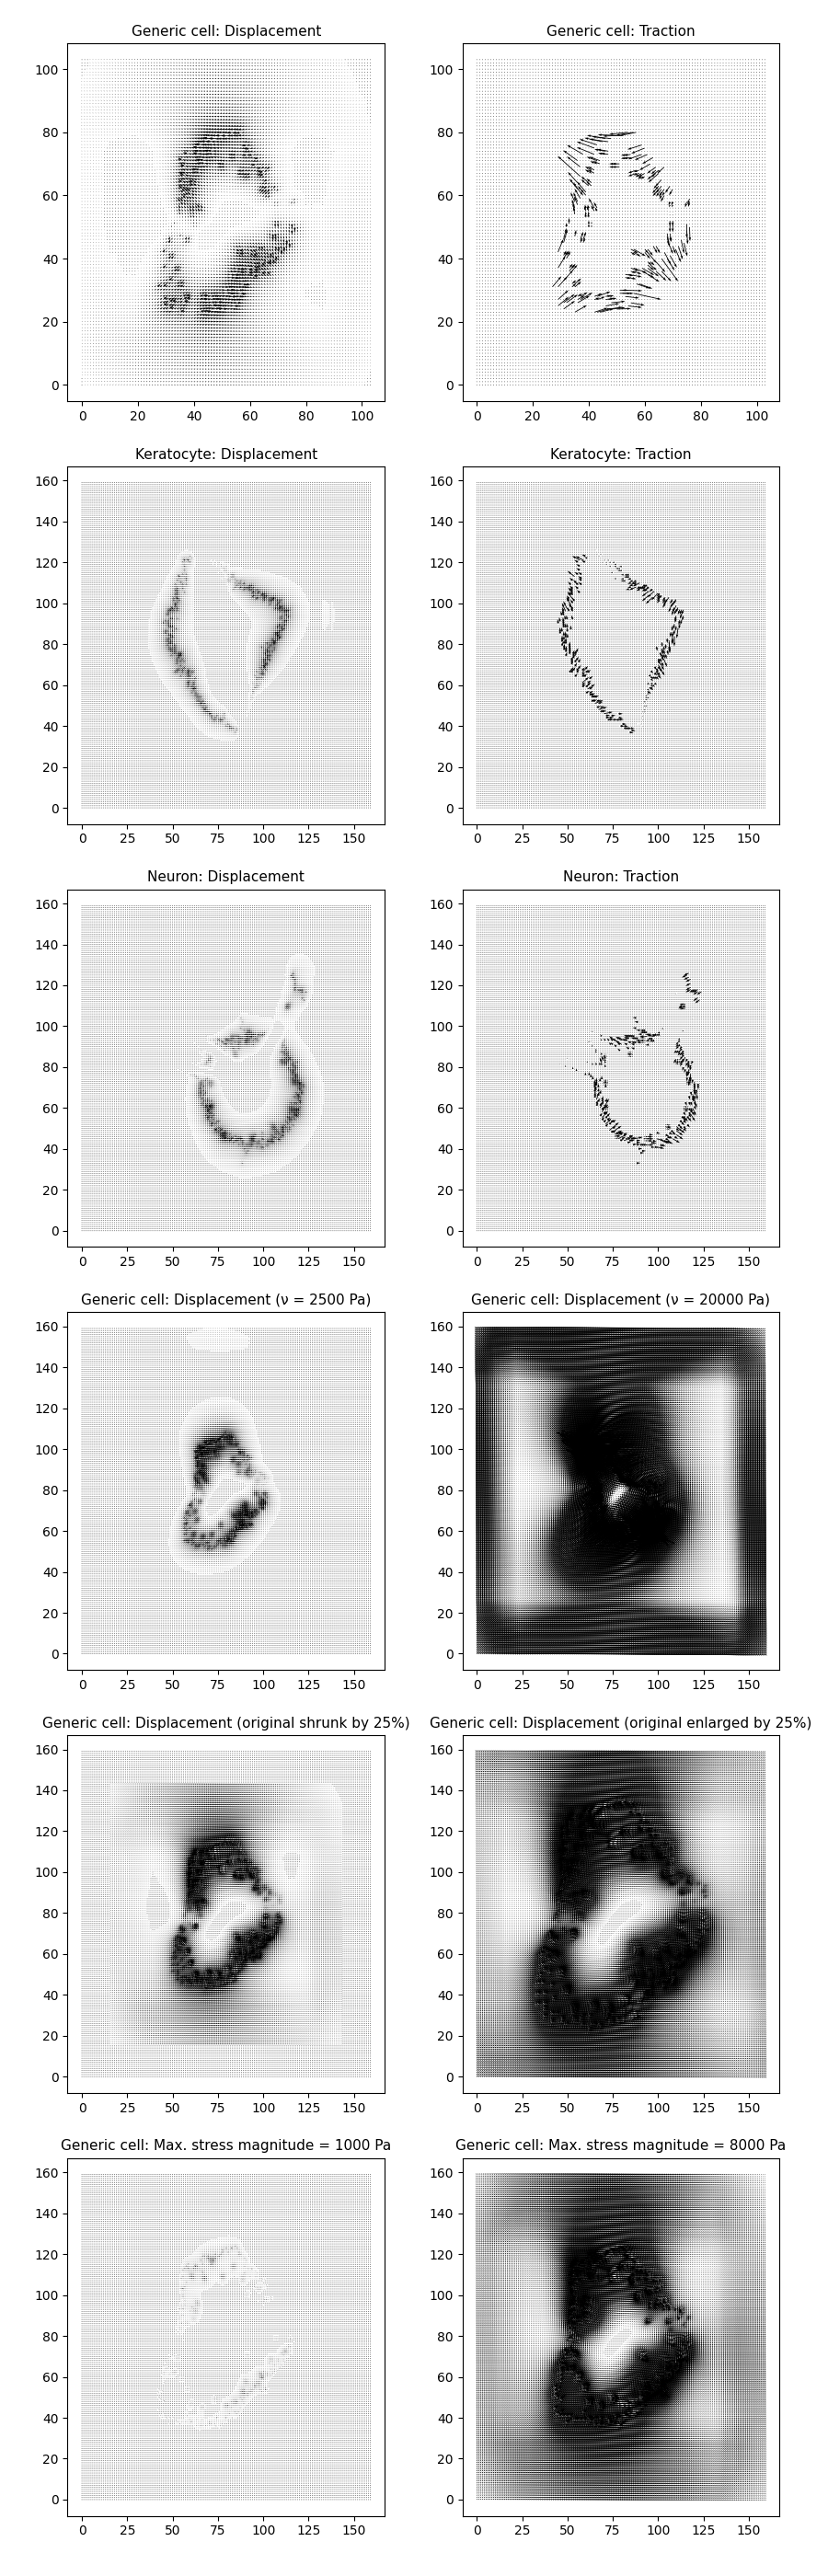

Text(0.5, 1.0, 'Generic cell: Max. stress magnitude = 8000 Pa')

In [123]:
samples_generic = matFiles_to_npArray('comparables/generic')
samples_keratocyte = matFiles_to_npArray('comparables/keratocyte')
samples_neuron = matFiles_to_npArray('comparables/neuron')
samples_elasticity = matFiles_to_npArray('comparables/elasticity')
samples_magnification_small = matFiles_to_npArray('comparables/magnification/S')
samples_magnification_large = matFiles_to_npArray('comparables/magnification/L')
samples_tracScale = matFiles_to_npArray('comparables/tracScale') 

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(6,2, figsize=(9, 28))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(samples_generic[1]['dspl'][:,:,0], samples_generic[1]['dspl'][:,:,1], scale=30)
axs[0, 0].set_title('Generic cell: Displacement', {'fontsize': 11})

axs[0, 1].quiver(samples_generic[0]['trac'][:,:,0], samples_generic[0]['trac'][:,:,1], scale=50000)
axs[0, 1].set_title('Generic cell: Traction', {'fontsize': 11})

axs[1, 0].quiver(samples_keratocyte[0]['dspl'][:,:,0], samples_keratocyte[0]['dspl'][:,:,1], scale=30)
axs[1, 0].set_title('Keratocyte: Displacement', {'fontsize': 11})

axs[1, 1].quiver(samples_keratocyte[1]['trac'][:,:,0], samples_keratocyte[1]['trac'][:,:,1], scale=50000)
axs[1, 1].set_title('Keratocyte: Traction', {'fontsize': 11})

axs[2, 0].quiver(samples_neuron[0]['dspl'][:,:,0], samples_neuron[0]['dspl'][:,:,1], scale=30)
axs[2, 0].set_title('Neuron: Displacement', {'fontsize': 11})

axs[2, 1].quiver(samples_neuron[1]['trac'][:,:,0], samples_neuron[1]['trac'][:,:,1], scale=50000)
axs[2, 1].set_title('Neuron: Traction', {'fontsize': 11})

axs[3, 0].quiver(samples_elasticity[0]['dspl'][:,:,0], samples_elasticity[0]['dspl'][:,:,1], scale=30)
axs[3, 0].set_title('Generic cell: Displacement (ν = 2500 Pa)', {'fontsize': 11})

axs[3, 1].quiver(samples_elasticity[1]['dspl'][:,:,0], samples_elasticity[1]['dspl'][:,:,1], scale=30)
axs[3, 1].set_title('Generic cell: Displacement (ν = 20000 Pa)', {'fontsize': 11})

axs[4, 0].quiver(samples_magnification_small[1]['dspl'][:,:,0], samples_magnification_small[1]['dspl'][:,:,1], scale=30)
axs[4, 0].set_title('Generic cell: Displacement (original shrunk by 25%)', {'fontsize': 11})

axs[4, 1].quiver(samples_magnification_large[1]['dspl'][:,:,0], samples_magnification_large[1]['dspl'][:,:,1], scale=30)
axs[4, 1].set_title('Generic cell: Displacement (original enlarged by 25%)', {'fontsize': 11})

axs[5, 0].quiver(samples_tracScale[1]['dspl'][:,:,0], samples_tracScale[1]['dspl'][:,:,1], scale=30)
axs[5, 0].set_title('Generic cell: Max. stress magnitude = 1000 Pa', {'fontsize': 11})

axs[5, 1].quiver(samples_tracScale[0]['dspl'][:,:,0], samples_tracScale[0]['dspl'][:,:,1], scale=30)
axs[5, 1].set_title('Generic cell: Max. stress magnitude = 8000 Pa', {'fontsize': 11})

### 2. [Experimental datasets](https://cmu.app.box.com/s/n34hbfopwa3r6rftvtfn4ckc403hk43d/folder/128446691101) by Wang and Lin 

| ID | #Samples | Sample size (h x w x ch) | Young's modulus (N/pixel) | Poisson ratio ν | Labeled (y/n)| #Classes | Extendable (y/n) |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | 1472 (cells) + 81 (radial patterns) |  104 x 104 x 2 | 10 | 0.45 | y | 1 | n
| 2 | 1472 (cells) + 81 (radial patterns)| 160 x 160 x 2 | 6.5 | 0.45 | y | 1 | n
| 3 | 1472 (cells) + 81 (radial patterns)| 256 x 256 x 2 | 4.1 | 0.45 | y | 1 | n